https://finance.yahoo.com/commodities/

https://gsnchez.com/blog/article/Optimizacion-algoritmica-de-carteras-con-markowitz

Importamos las librerias necesarias.

In [21]:
import pandas as pd
import numpy as np
from pandas_datareader import data as wb
from time import time
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process.kernels import ConstantKernel, WhiteKernel, RationalQuadratic, RBF
from sklearn.gaussian_process import GaussianProcessRegressor
import warnings
warnings.filterwarnings("ignore")

In [22]:
symbols = pd.read_csv('futures.txt', sep=';', header = 0)

Descargamos el dataset a estudiar.

In [23]:
stock = symbols[symbols['Name'] == 'Natural Gas']['symbol'].values[0]
natural_gas = wb.DataReader(stock, data_source='yahoo', start='1900-1-1')

In [24]:
natural_gas.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-08-30,4.815,4.63,4.65,4.805,34954.0,4.805
2000-08-31,4.870,4.74,4.82,4.780,25787.0,4.780
2000-09-01,4.860,4.75,4.75,4.835,113.0,4.835
2000-09-05,4.975,4.84,4.85,4.960,26096.0,4.960
2000-09-06,5.110,4.96,4.99,5.065,32764.0,5.065


Transformamos el dataset a series de precios (Adj Close) anuales.

In [25]:
starts, ends = [], []
for i in range(1,22):
    starts.append('20{:02d}-01-01'.format(i))
    ends.append('20{:02d}-12-31'.format(i))

In [26]:
sd = np.std(natural_gas['Adj Close'].values)
natural_gas_years = pd.DataFrame()
for start, end in zip(starts, ends):
    s = [None] * 253
    v = natural_gas['Adj Close'][start:end].values
    v = (v - v[0]) / sd
    s[:len(v)] = v
    natural_gas_years[end[:4]] = s

In [27]:
natural_gas_years.head()

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.064249,-0.087897,0.041494,0.113775,0.049972,-0.191410,-0.060680,-0.078527,0.045064,-0.110205,...,0.045956,-0.015616,-0.007585,-0.053987,-0.004016,-0.026771,-0.021417,-0.005800,0.003569,0.053987
2,0.283768,-0.084773,-0.140992,0.022755,0.019186,-0.502841,-0.061126,-0.004016,0.005354,0.055772,...,-0.005800,0.024093,-0.006693,-0.029002,-0.029894,-0.024093,-0.078527,0.038371,0.005800,0.060234
3,0.395312,-0.086112,-0.055326,0.119129,0.115560,-0.443500,-0.051310,0.012939,-0.044171,-0.034802,...,0.030786,0.014724,-0.009816,-0.058895,0.021416,-0.018739,-0.116452,-0.006246,0.017847,0.066034
4,0.596092,-0.082096,-0.040156,0.205241,0.094143,-0.551474,0.035248,0.052203,-0.173117,-0.060234,...,0.008031,-0.006693,-0.046849,-0.033909,0.061572,-0.099944,-0.098605,0.004016,0.008477,0.053095


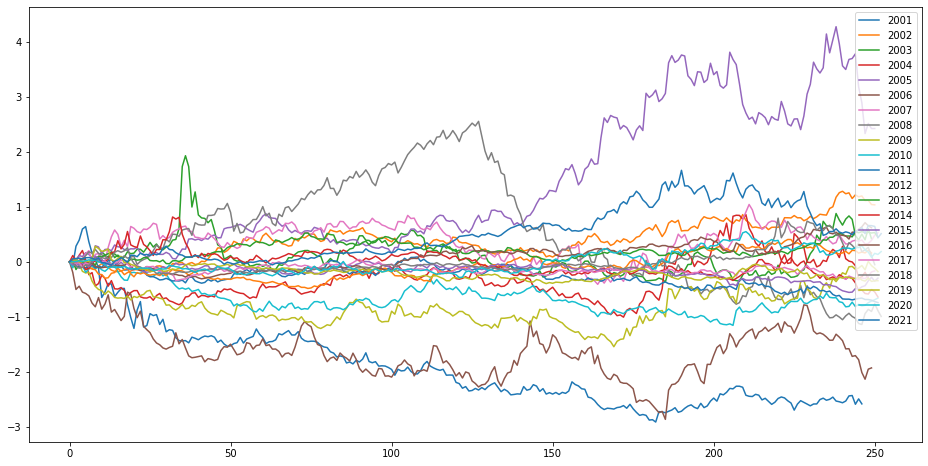

In [28]:
natural_gas_plot = natural_gas_years.plot(figsize=(16,8), legend=True, linewidth=1.5)

Obtenemos las matrices X e y. La matriz X tiene como columnas la variable año actual y la variable dia actual. La matriz y tiene los precios correspondientes a cada fila de X.

In [29]:
days = natural_gas_years.index.values
years = [int(year) for year in natural_gas_years.columns.values]

X = pd.DataFrame(columns=['year', 'day'])
y, i = np.array([None] * len(years) * len(days)), 0
for year in years:
    for day in days:
        X.loc[i, 'year'], X.loc[i, 'day'] = year, day
        y[i] = natural_gas_years[str(year)].values[day]
        i += 1

X = X.loc[~np.isnan(list(y)),:].reset_index(drop=True)
y = y[~np.isnan(list(y))]

Iteramos entrenando un GP con kernel rbf sobre los años anteriores a n y el primer trimeste de n, y predecimos el resto del año n para n entre 2016 y 2021.

In [31]:
natural_gas_years

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.064249,-0.087897,0.041494,0.113775,0.049972,-0.191410,-0.060680,-0.078527,0.045064,-0.110205,...,0.045956,-0.015616,-0.007585,-0.053987,-0.004016,-0.026771,-0.021417,-0.005800,0.003569,0.053987
2,0.283768,-0.084773,-0.140992,0.022755,0.019186,-0.502841,-0.061126,-0.004016,0.005354,0.055772,...,-0.005800,0.024093,-0.006693,-0.029002,-0.029894,-0.024093,-0.078527,0.038371,0.005800,0.060234
3,0.395312,-0.086112,-0.055326,0.119129,0.115560,-0.443500,-0.051310,0.012939,-0.044171,-0.034802,...,0.030786,0.014724,-0.009816,-0.058895,0.021416,-0.018739,-0.116452,-0.006246,0.017847,0.066034
4,0.596092,-0.082096,-0.040156,0.205241,0.094143,-0.551474,0.035248,0.052203,-0.173117,-0.060234,...,0.008031,-0.006693,-0.046849,-0.033909,0.061572,-0.099944,-0.098605,0.004016,0.008477,0.053095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,NaN,1.117672,0.601892,-0.302508,2.516882,-1.953361,0.333294,-0.865583,0.008477,-0.744222,...,0.212380,0.535412,-0.586276,-0.345787,0.654987,-0.262798,0.261459,-0.296261,0.176686,0.659895
249,NaN,1.041822,0.418514,NaN,2.424077,-1.930606,0.389512,-0.903061,-0.070050,-0.712544,...,0.159731,0.523811,-0.505072,-0.281537,0.620185,-0.184271,0.110206,-0.356941,0.081650,0.657664
250,NaN,1.036914,NaN,NaN,2.424970,NaN,0.484994,-0.764747,-0.116898,-0.689789,...,NaN,0.532735,-0.547459,-0.352033,NaN,-0.166870,-0.051756,-0.344448,0.153931,0.643833
251,NaN,NaN,NaN,NaN,NaN,NaN,0.528273,-0.888337,-0.178025,-0.659895,...,NaN,0.444838,-0.638925,-0.297154,NaN,NaN,NaN,-0.343110,0.133853,0.437253


Predicting year 2011 with data from 2005 to 2010
Elapsed time: 57.006s
Log-marginal-likelihood: 1085.881
Predicting year 2012 with data from 2006 to 2011
Elapsed time: 51.558s
Log-marginal-likelihood: 979.236
Predicting year 2013 with data from 2007 to 2012
Elapsed time: 41.914s
Log-marginal-likelihood: 893.821
Predicting year 2014 with data from 2008 to 2013
Elapsed time: 44.370s
Log-marginal-likelihood: 987.090
Predicting year 2015 with data from 2009 to 2014
Elapsed time: 42.338s
Log-marginal-likelihood: 838.129
Predicting year 2016 with data from 2010 to 2015
Elapsed time: 41.336s
Log-marginal-likelihood: 748.493
Predicting year 2017 with data from 2011 to 2016
Elapsed time: 46.547s
Log-marginal-likelihood: 445.554
Predicting year 2018 with data from 2012 to 2017
Elapsed time: 40.299s
Log-marginal-likelihood: 308.725
Predicting year 2019 with data from 2013 to 2018
Elapsed time: 38.429s
Log-marginal-likelihood: 190.951
Predicting year 2020 with data from 2014 to 2019
Elapsed time: 

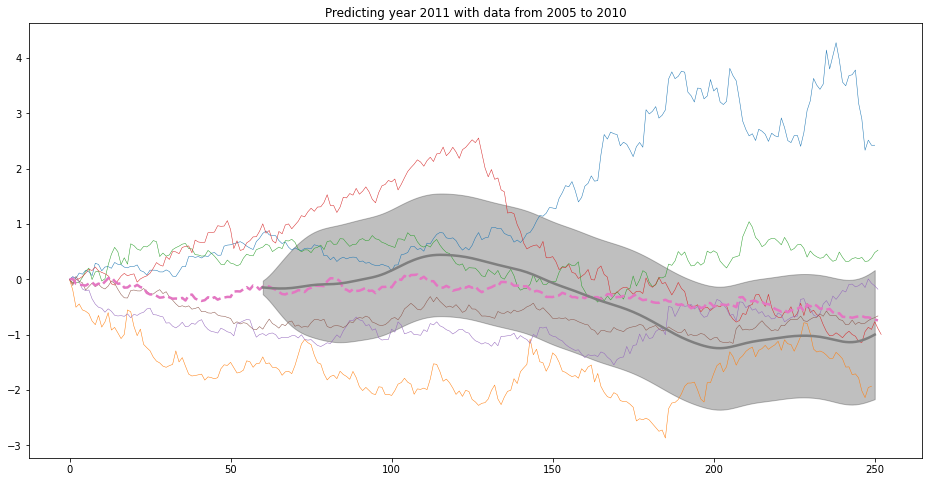

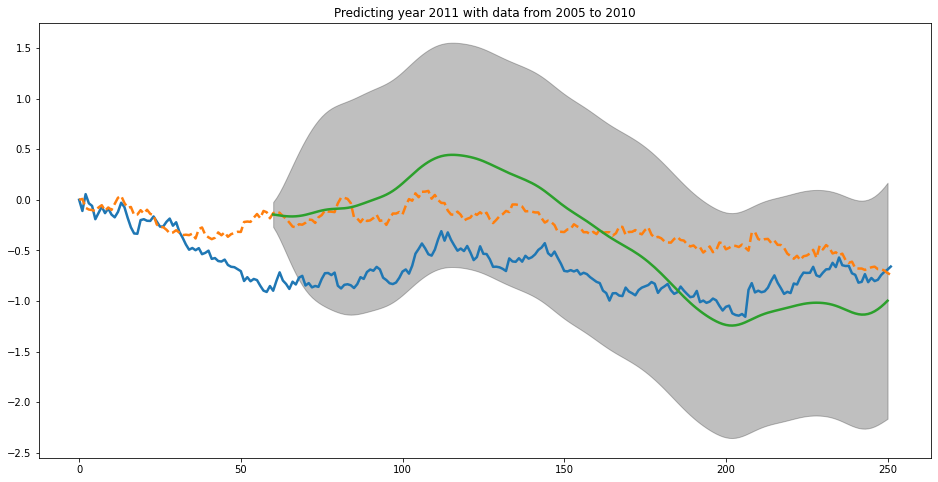

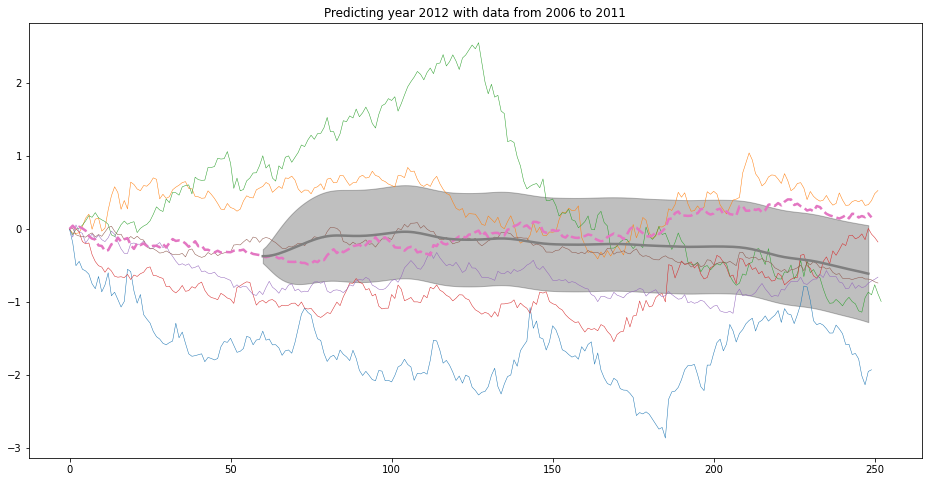

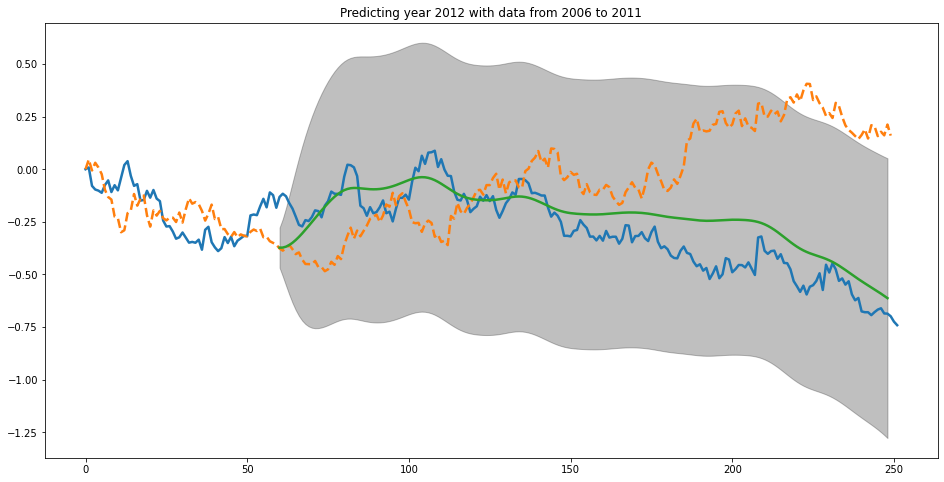

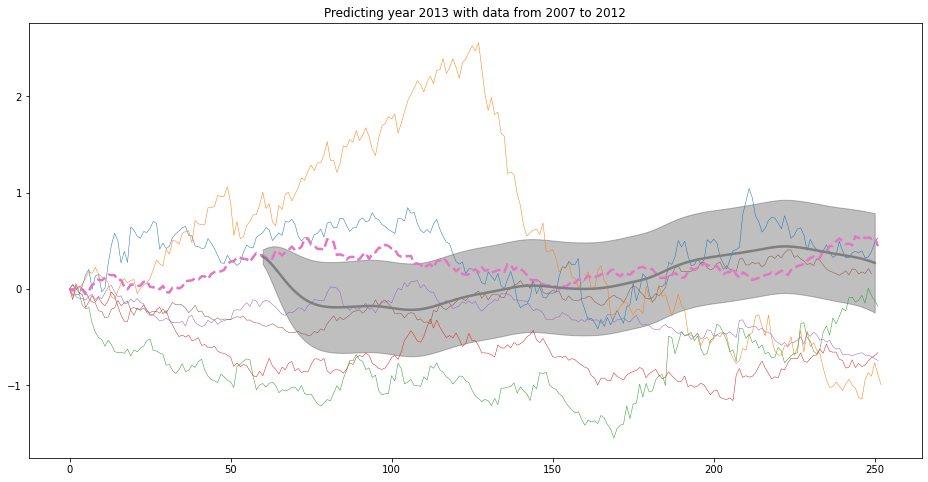

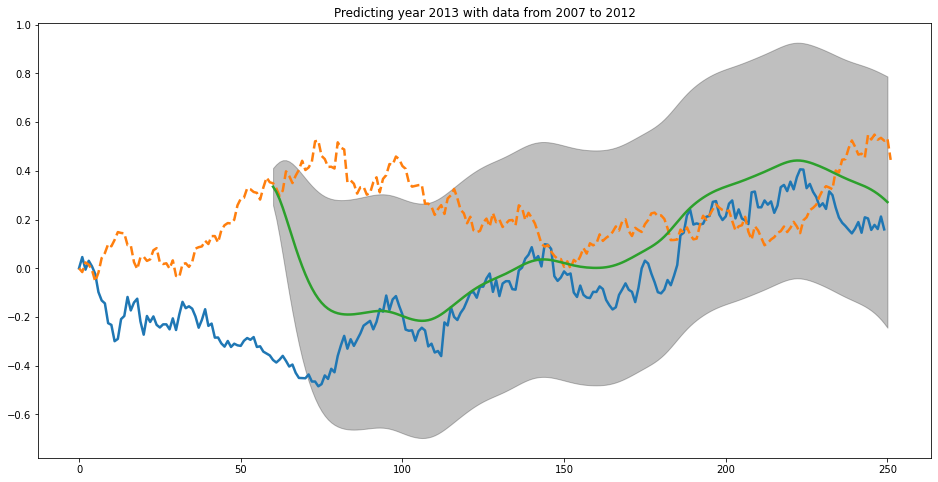

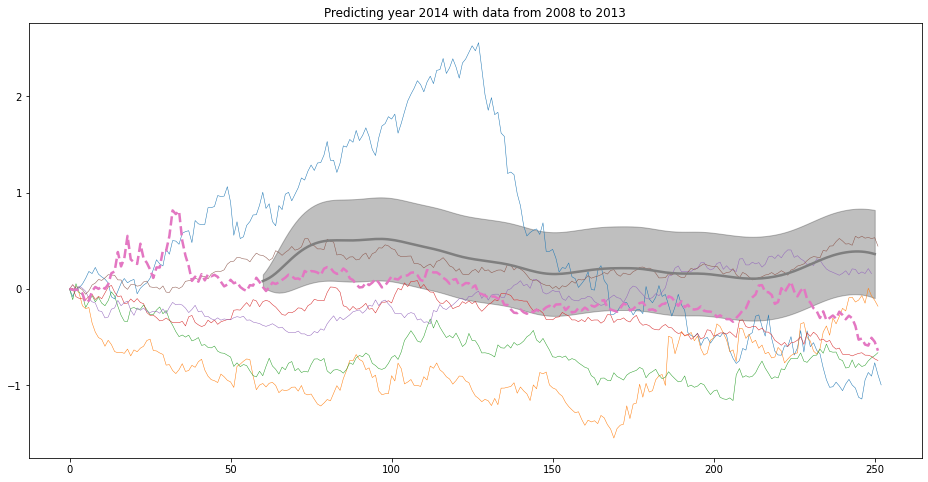

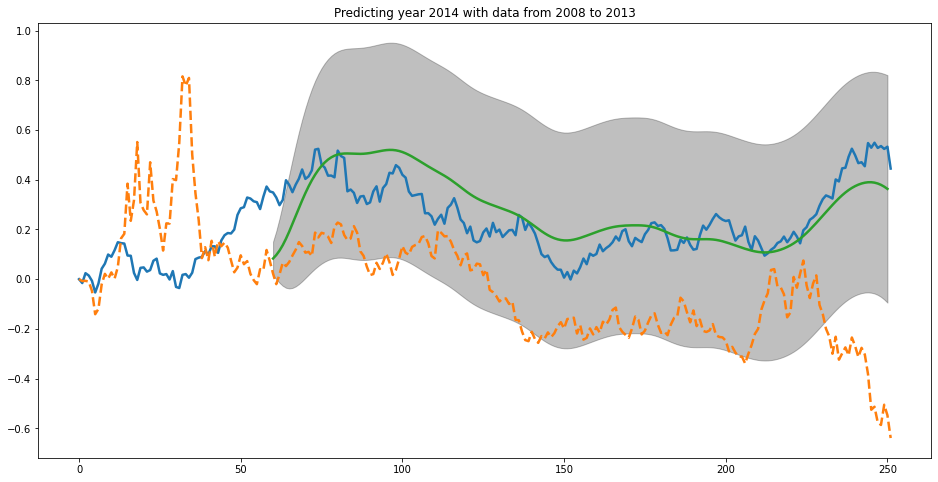

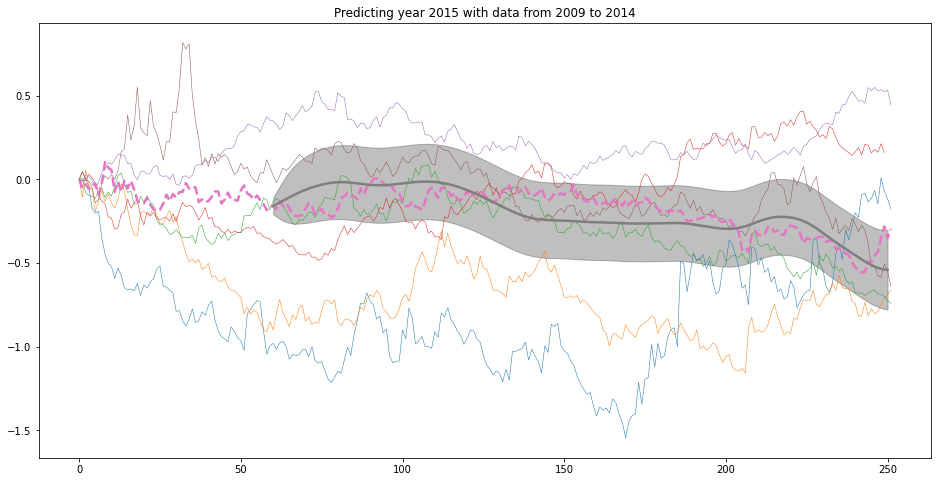

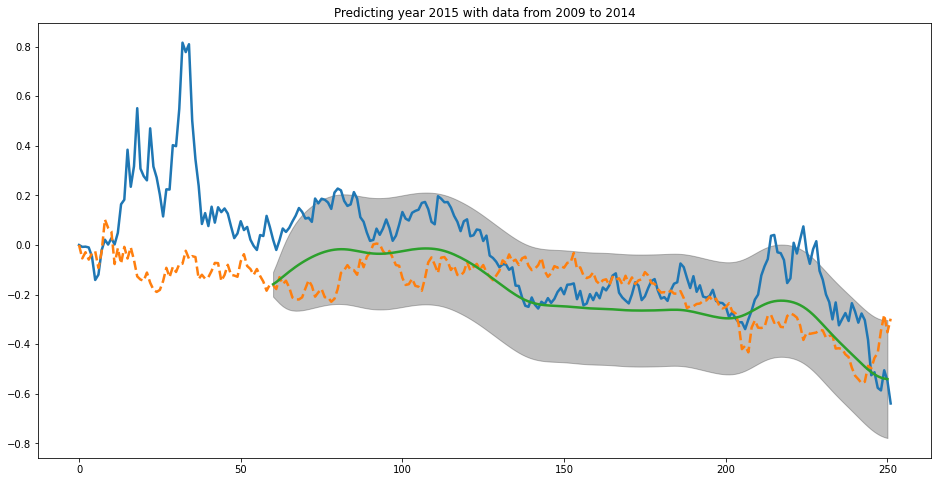

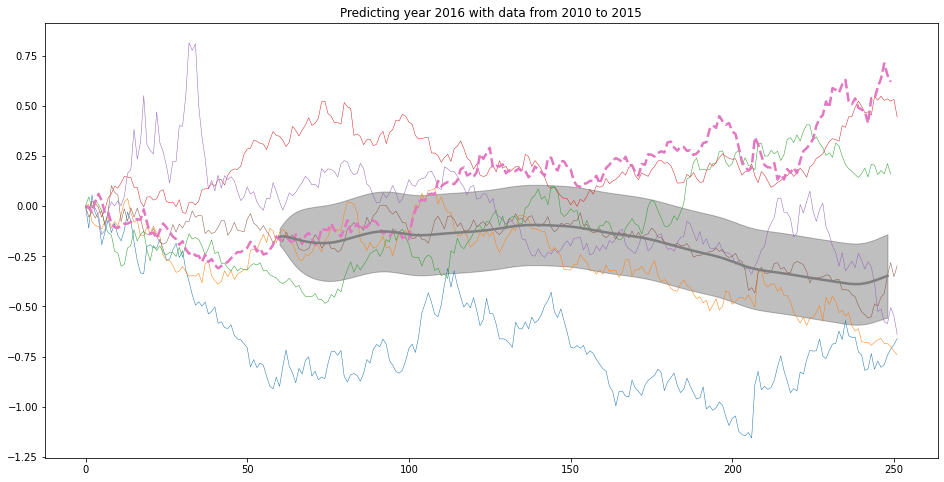

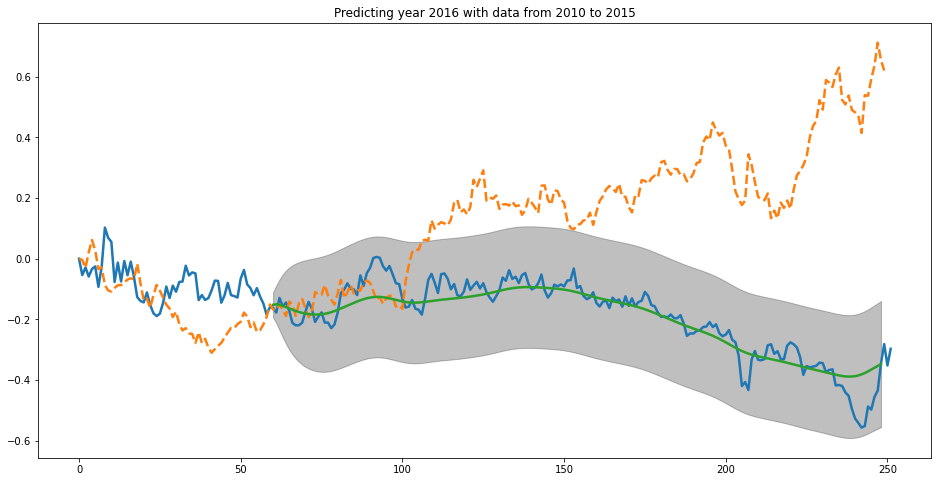

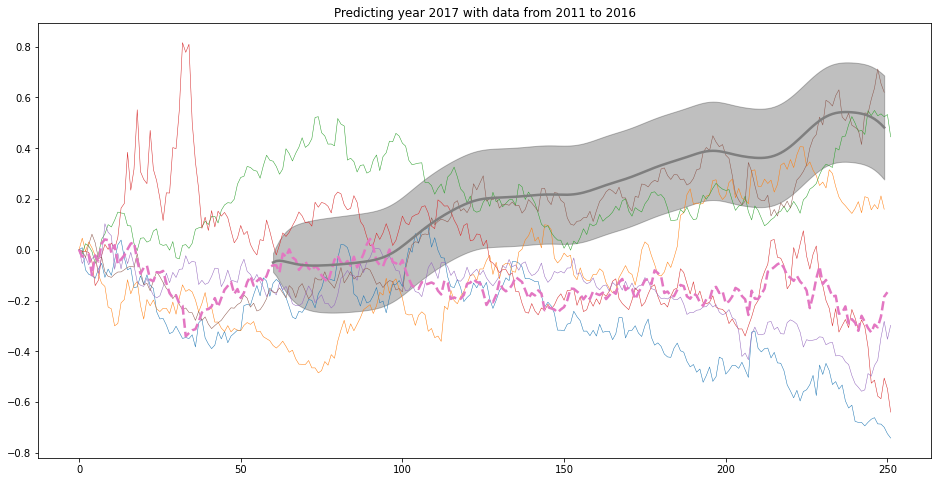

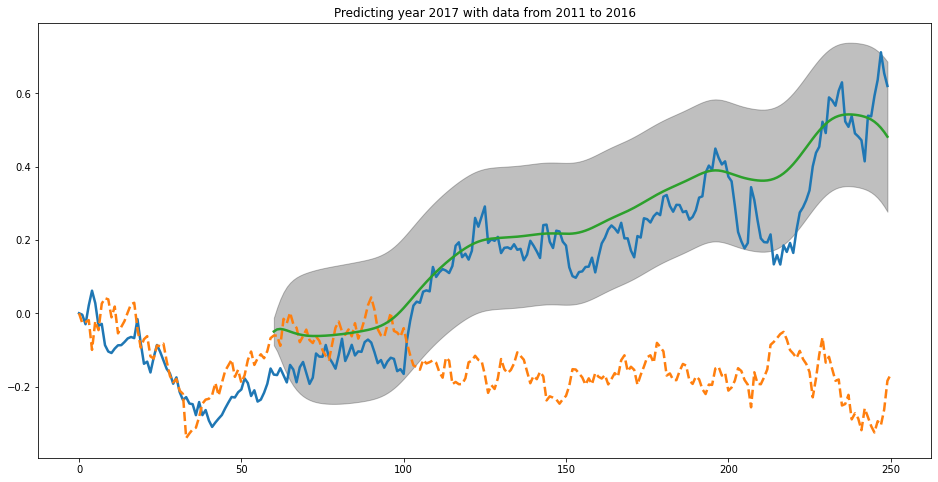

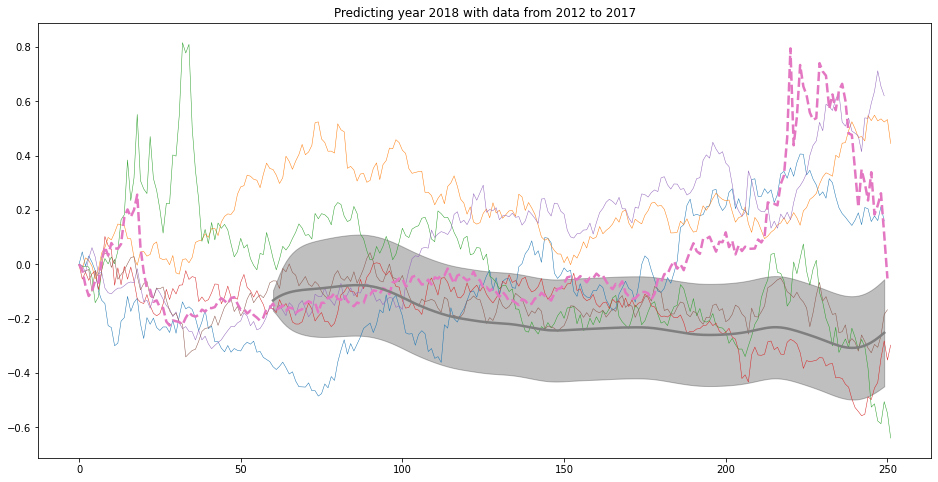

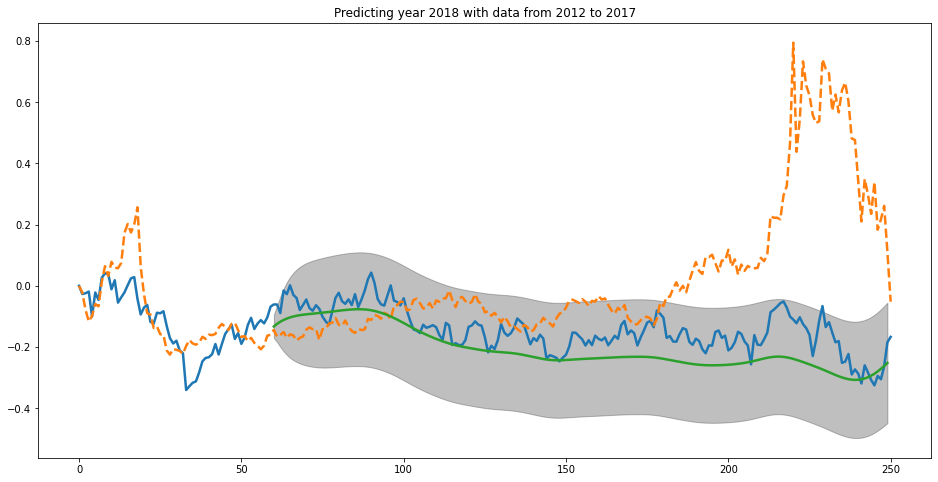

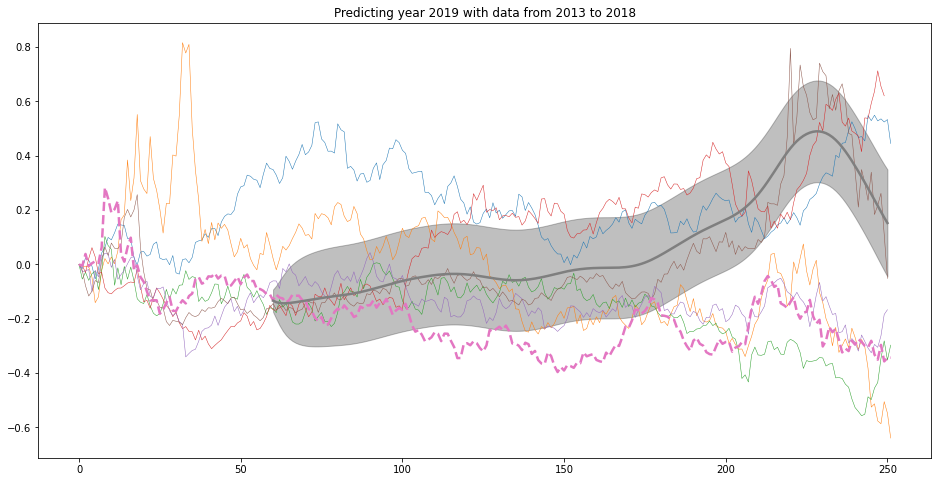

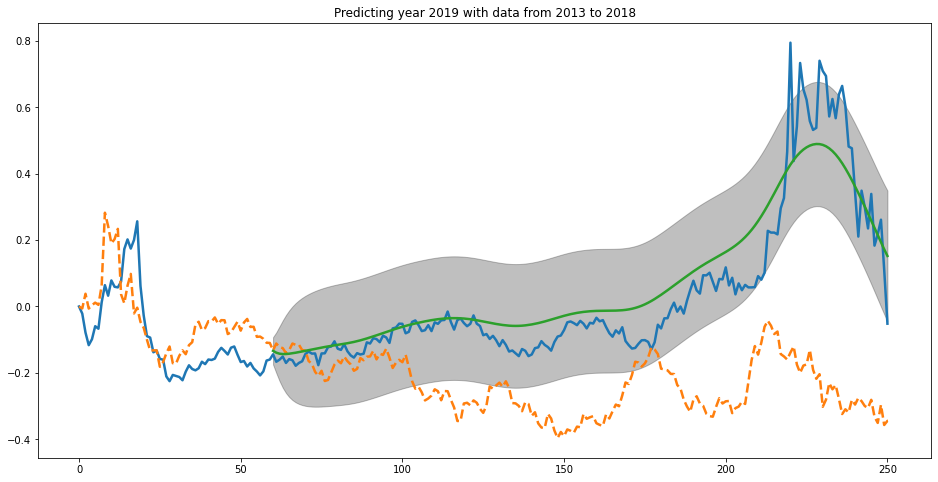

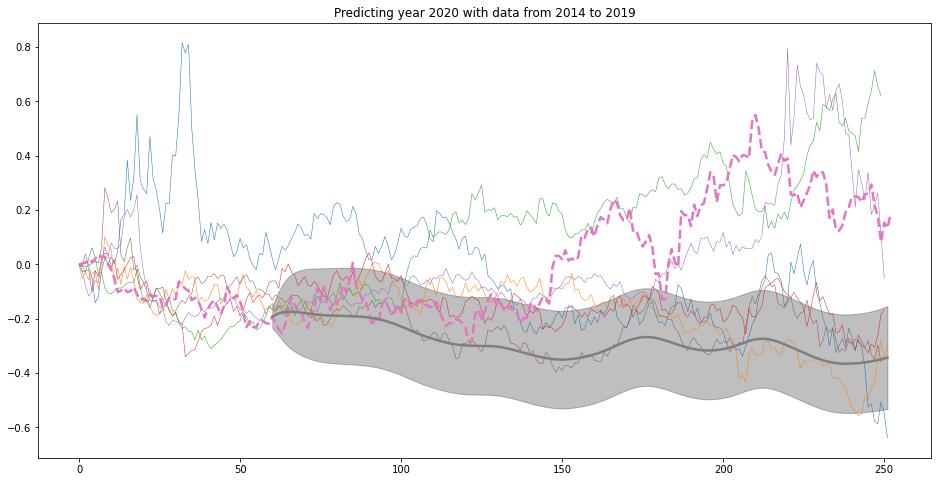

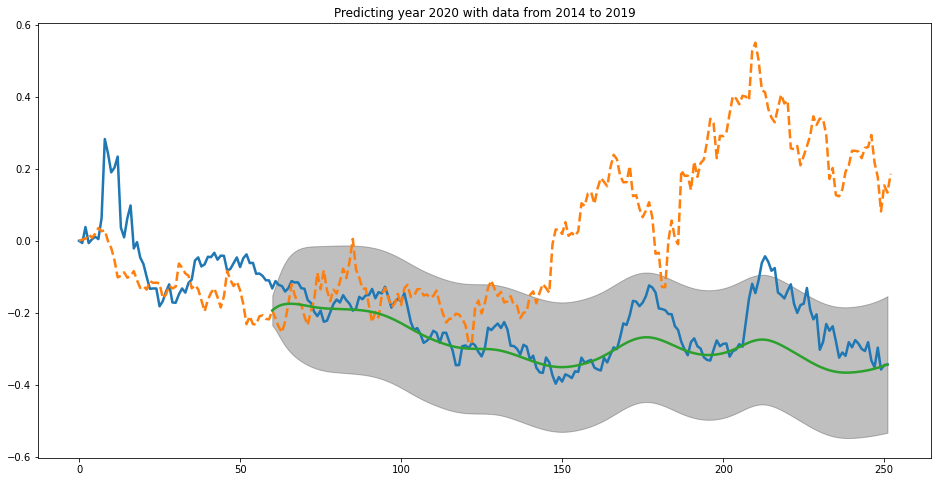

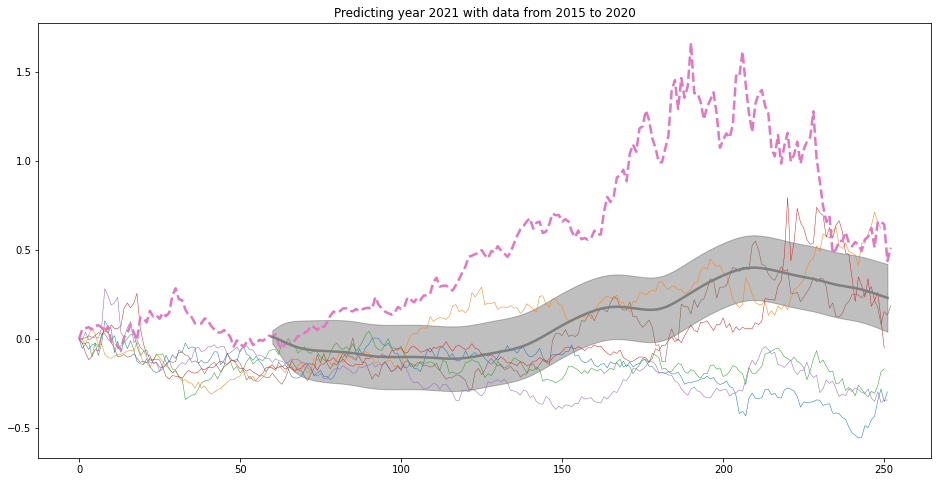

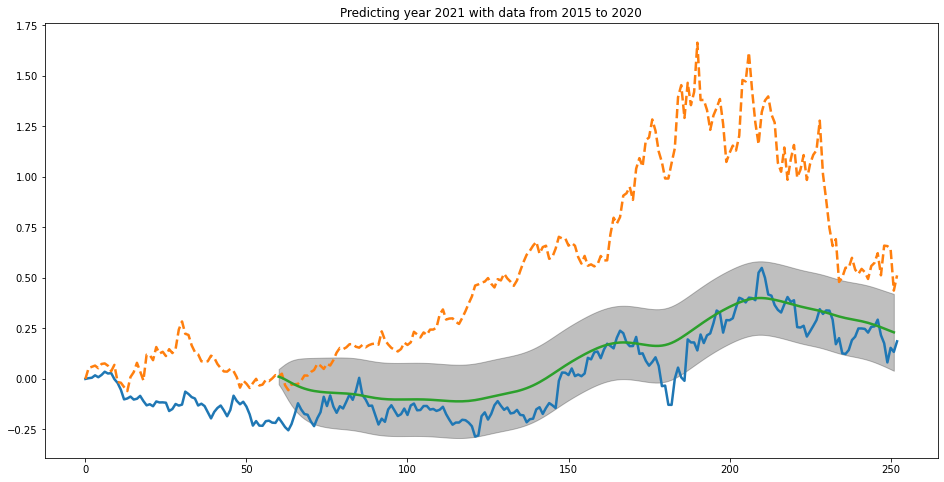

In [34]:
years_pred, days_pred, n_years = range(2011, 2022), 60, 6

sc = StandardScaler()
sc.fit_transform(X)

for year_pred in years_pred:
    
    title = 'Predicting year {} with data from {} to {}'.format(year_pred, year_pred - n_years, year_pred - 1)
    print(title)
    
    mask_train = ((X['year'] >= year_pred - n_years) & (X['year'] < year_pred)) | ((X['year'] == year_pred) & (X['day'] <= days_pred))
    mask_test = (X['year'] == year_pred) & (X['day'] > days_pred)
    
    X_train = X.loc[mask_train]
    X_train = pd.DataFrame(sc.transform(X_train), columns=['year', 'day'])
    y_train = y[mask_train]
    
    X_test = X.loc[mask_test]
    X_test = pd.DataFrame(sc.transform(X_test), columns=['year', 'day'])
    y_test = y[mask_test]
    
    kernel = ConstantKernel() * RationalQuadratic() + ConstantKernel() * WhiteKernel()
    gp = GaussianProcessRegressor(kernel=kernel,
                                  normalize_y=True,
                                  n_restarts_optimizer=1,
                                  alpha=0.01,
                                  random_state=0)
    t0 = time()
    gp.fit(X_train, y_train)
    print("Elapsed time: %0.3fs" % (time() - t0))
    print("Log-marginal-likelihood: %.3f" % gp.log_marginal_likelihood(gp.kernel_.theta))
    
    y_pred, y_std = gp.predict(X_test, return_std=True)
    
    hco = natural_gas_years.loc[:,'{}-01-01'.format(year_pred - n_years - 1):'{}-01-01'.format(year_pred - 1)].plot(figsize=(16,8), legend=False, linewidth=.5, title=title)
    p = hco.plot(natural_gas_years[str(year_pred)], linewidth=2.5, linestyle='--')
    y_plot, y_plot[days_pred:] = [None] * (len(y_pred) + days_pred), y_pred
    p = hco.plot(y_plot, linewidth=2.5)
    p = hco.fill_between(range(days_pred, len(y_pred) + days_pred), y_pred - y_std, y_pred + y_std, alpha=0.25, color='k')
    f = hco.get_figure()
    f.savefig('Figures/{}.png'.format(year_pred))

    hco = natural_gas_years.loc[:,'{}-01-01'.format(year_pred - 2):'{}-01-01'.format(year_pred - 1)].plot(figsize=(16,8), legend=False, linewidth=2.5, title=title)
    p = hco.plot(natural_gas_years[str(year_pred)], linewidth=2.5, linestyle='--')
    y_plot, y_plot[days_pred:] = [None] * (len(y_pred) + days_pred), y_pred
    p = hco.plot(y_plot, linewidth=2.5)
    p = hco.fill_between(range(days_pred, len(y_pred) + days_pred), y_pred - y_std, y_pred + y_std, alpha=0.25, color='k')
    f = hco.get_figure()
    f.savefig('Figures/{}_last.png'.format(year_pred))